In [1]:
%%time
import bayes3d as b

CPU times: user 4.13 s, sys: 1.92 s, total: 6.05 s
Wall time: 3.43 s


In [2]:
import numpy as np
import os
import jax
import jax.numpy as jnp
import trimesh
import time
import pickle
import bayes3d.transforms_3d as t3d
import bayes3d as b
import bayes3d as j
import bayes3d.meshcat
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import namedtuple


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


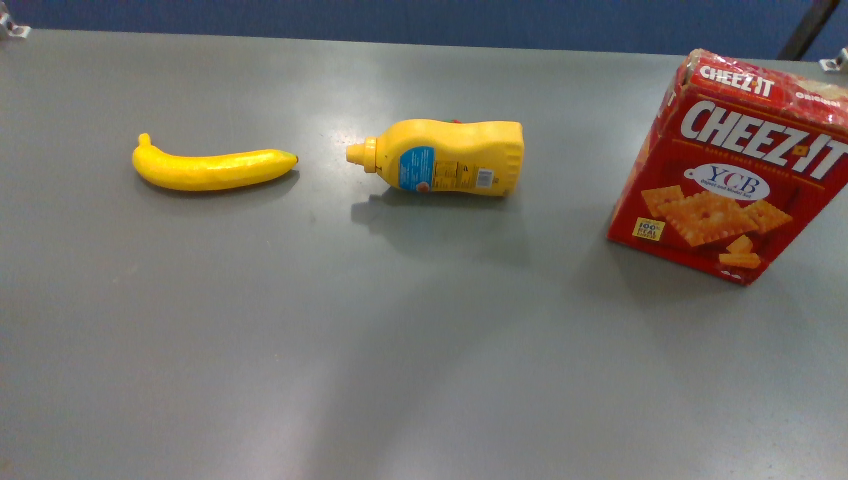

In [4]:
test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/cracker_sugar_banana_real.pkl.rgbds")
test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/strawberry_error.pkl.rgbds")
test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/demo2_nolight.pkl.rgbds")
with  open(test_pkl_file,'rb') as f:
    rgbds = pickle.load(f)
image = rgbds[0]
b.get_rgb_image(image.rgb)

In [5]:
!ls /home/nishadgothoskar/bayes3d/assets/sample_imgs/

cracker_sugar_banana_real.pkl	     mustard.pkl
cracker_sugar_banana_real.pkl.rgbds  mustard_tag.pkl
demo2_nolight.pkl		     new_utencils.pkl
demo2_nolight.pkl.rgbds		     red_lego.pkl
knife_sim.pkl			     red_lego.pkl.rgbds
knife_sim.pkl.rgbds		     red_lego_multi.pkl
knife_spoon.pkl			     red_lego_multi.pkl.rgbds
knife_spoon_box_real.pkl	     spoon_learning.pkl
knife_spoon_box_real.pkl.rgbds	     spoon_learning.pkl.rgbds
knife_spoon_real.pkl		     strawberry_error.pkl
knife_spoon_real.pkl.rgbds	     strawberry_error.pkl.rgbds
lego_learning.pkl		     tag.pkl
lego_learning.pkl.rgbds		     utensils.pkl
lego_tag.pkl			     utensils.pkl.rgbds


In [7]:
import cv2

In [8]:
original_pc_image = b.t3d.unproject_depth_jit(image.depth, image.intrinsics)
scaling_factor = 0.25
intrinsics = b.camera.scale_camera_parameters(image.intrinsics, scaling_factor)

w,h = intrinsics.width, intrinsics.height
observed_point_cloud_image = cv2.resize(np.asarray(original_pc_image, dtype=original_pc_image.dtype), (w,h),interpolation=0).astype(original_pc_image.dtype)

In [9]:
plane_pose, plane_dims = b.utils.find_plane_and_dims(observed_point_cloud_image.reshape(-1,3))
if plane_pose[:3,2][2] > 0:
    plane_pose = plane_pose @ t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)
b.clear()
b.show_cloud("1", observed_point_cloud_image.reshape(-1,3))
b.show_pose("2", plane_pose)

In [10]:
renderer = b.Renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path,scaling_factor=1.0/1000.0)
SCALING_FACTOR = 3

table_mesh = j.mesh.make_cuboid_mesh(3*plane_dims)
renderer.add_mesh(table_mesh)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 128, 1024)


In [43]:
def score_trace(trace):
    reconstruction = renderer.render_multiobject(
        trace.poses , trace.ids
    )
    p = b.threedp3_likelihood_multi_r_jit(
        trace.observation, reconstruction[:,:,:3], reconstruction[:,:, -1],
        trace.variances, trace.outlier_prob, OUTLIER_VOLUME,
        3
    )
    return p

def render_image(trace):
    reconstruction = renderer.render_multiobject(
        trace.poses , trace.ids
    )
    return reconstruction

def score_traces(traces, renderer):
    reconstruction = renderer.render_multiobject_parallel(
        traces.all_poses , traces.ids
    )
    p = b.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(
        traces.observation, reconstruction[:,:,:,:3], reconstruction[:,:,:, -1],
        traces.all_variances, traces.all_outlier_prob, OUTLIER_VOLUME,
        3
    )
    return p

Trace = namedtuple('Trace', ['poses', 'ids', 'variances', 'outlier_prob', 'observation'])
Traces = namedtuple('Traces', ['all_poses', 'ids', 'all_variances', 'all_outlier_prob', 'observation'])

In [73]:
VARIANCE_GRID = jnp.array([0.0001]).reshape(-1,1)
OUTLIER_GRID = jnp.linspace(0.01, 0.4, 3)
OUTLIER_VOLUME = 100.0**3

grid_params = [
    (0.2, jnp.pi, (11,11,5)), (0.1, jnp.pi/5, (11,11,5)), (0.1, jnp.pi/5, (11,11,5)),
    (0.0, jnp.pi, (1,1,7*7)), (0.05, jnp.pi/5/5, (11,11,5))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

contact_poses_jit = jax.jit(jax.vmap(b.scene_graph.relative_pose_from_edge, in_axes=(0,None, None)))


In [74]:
contact_plane = plane_pose
trace = Trace(
    plane_pose[None,...], [21],
    jnp.array([0.0001, 0.0001]), 0.01,
    observed_point_cloud_image
)

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.96it/s]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 9 18 19  7 16  5 17  8  3 13 20  6 12  4  1  0  2 15 10 14 11]
[21, 1, 8, 20, 9]


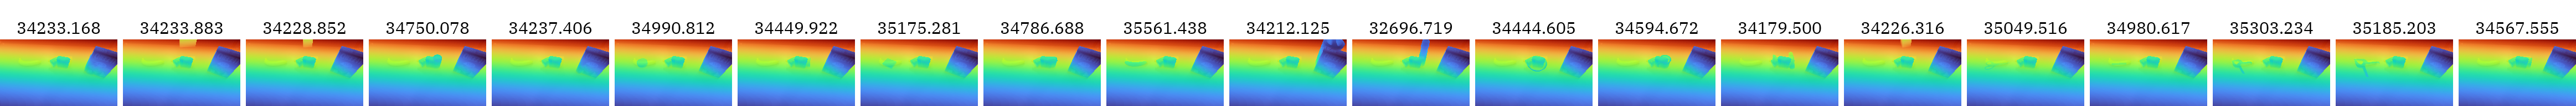

In [85]:
all_hypotheses = []
all_traces = []
for obj_id in tqdm(range(21)):
    contact_param = jnp.zeros(3)
    p = None
    traces = None
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

        potential_new_object_poses = contact_plane @ contact_poses_jit(
            contact_param_grid,
            3,
            renderer.model_box_dims[obj_id],
        )
        POTENTIAL_R = jnp.hstack([jnp.tile(trace.variances[None,:], (VARIANCE_GRID.shape[0], 1)),VARIANCE_GRID])

        potential_poses = jnp.concatenate(
            [
                jnp.tile(trace.poses[:,None,...], (1,potential_new_object_poses.shape[0],1,1)),
                potential_new_object_poses[None,...]
            ]
        )
        
        traces = Traces(
            potential_poses, trace.ids + [obj_id], POTENTIAL_R, OUTLIER_GRID, trace.observation
        )
        p = score_traces(traces)      
        
        ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
        contact_param = contact_param_grid[ii]
    
    best_trace = Trace(
        traces.all_poses[:,ii], traces.ids, traces.all_variances[jj], traces.all_outlier_prob[kk], traces.observation
    )

    all_traces.append(
        best_trace
    )
    
scores = jnp.array([score_trace(t) for t in all_traces])
print(b.utils.normalize_log_scores(scores))
print(jnp.argsort(-scores))
trace = all_traces[jnp.argmax(scores)]

print(trace.ids)

rendered_images = [render_image(t) for t in all_traces]

rgb_viz = j.scale_image(j.get_rgb_image(image.rgb),scaling_factor)
j.multi_panel(
    [j.overlay_image(rgb_viz,j.get_depth_image(i[:,:,2]),0.9) for i in rendered_images],
    labels=["{:0.3f}".format(f) for f in scores]
)

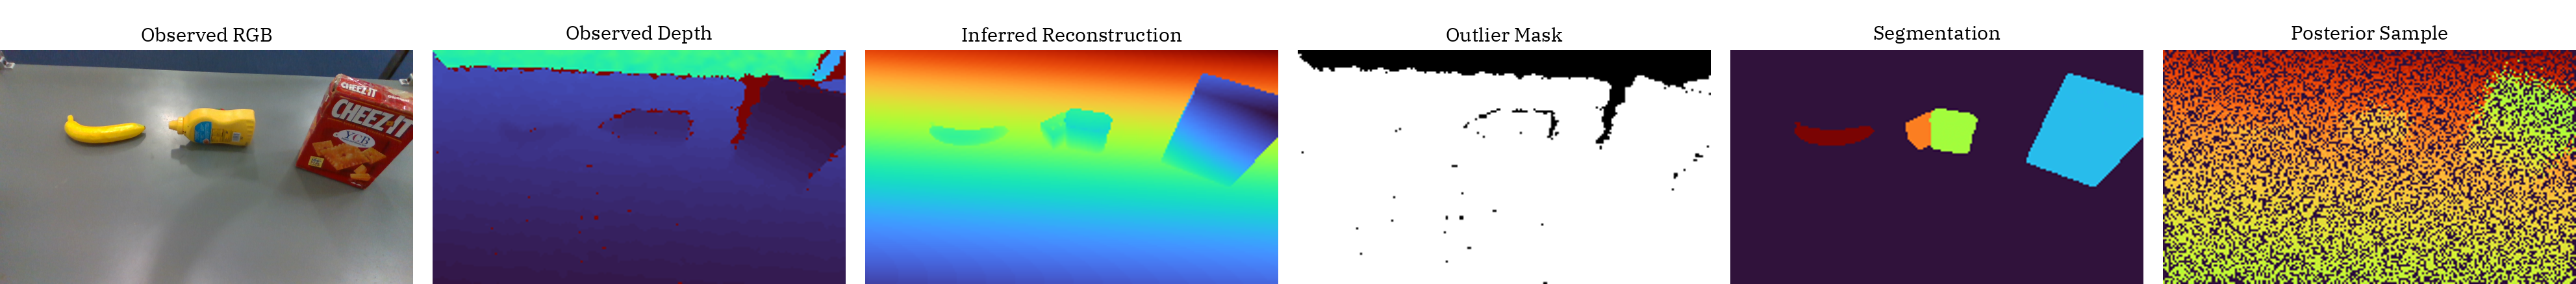

In [86]:

rgb = image.rgb
reconstruction = renderer.render_multiobject(
    trace.poses, trace.ids
)
inliers = (
    (jnp.log(1.0 - trace.outlier_prob)  + j.threedp3_likelihood_multi_r_per_pixel_jit(
        observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], trace.variances, 0.0, 1.0,3
    ))
        >
    jnp.log(trace.outlier_prob / OUTLIER_VOLUME)
)

rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])

variances = trace.variances
r = variances[jnp.abs(rendered_seg[..., None] - jnp.arange(len(variances))).argmin(-1)]
key = jax.random.PRNGKey(12)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)

viz2 = j.multi_panel(
    [
        j.scale_image(j.get_rgb_image(rgb),SCALING_FACTOR/4),
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *inliers,cmap=plt.cm.gray, min=0.0, max=1.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,3], max=5.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(img[:,:,2]), SCALING_FACTOR),
    ],
    labels=[
        "Observed RGB",
        "Observed Depth",
        "Inferred Reconstruction",
        "Outlier Mask",
        "Segmentation",
        "Posterior Sample",
    ],
    middle_width=30
)

viz2

In [87]:
j.clear()
b.show_cloud("1", trace.observation.reshape(-1,3))
for i in range(len(trace.ids)):
    j.show_trimesh(f"obj_{i}", renderer.meshes[trace.ids[i]])
    j.set_pose(f"obj_{i}", trace.poses[i])

In [72]:
trace.variances

Array([1.e-04, 1.e-04, 1.e-04], dtype=float32)